In this notebook, we will implement a 3-layer convolutional neural network with a fully connected layer in order to recognize sign language.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/sign_mnist_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/sign_mnist_test.csv')

# Data Preprocessing

The data have 784 pixels for each image and a label that shows an English letter index based on the English alphabet.

In [3]:
train_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [4]:
y_train = train_data['label']
x_train = train_data.drop('label', axis=1)

y_test = test_data['label']
x_test = test_data.drop('label', axis=1)

In [5]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Visualize Data

By converting 784 pixels into 28*28 pixels and using the Matplotlib library we illustrate random images from the dataset.

In [6]:
sign_dictionary = {
    0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5: 'F', 6: 'G', 7:'H', 8: 'I', 9:'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P',
    16: 'Q', 17: 'R', 18:'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}

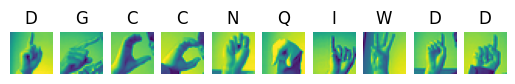

In [7]:
fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28))
    ax[i].axis('off')
    ax[i].set_title(sign_dictionary[y_train[i]])

Normalize Pixels

In [8]:
x_train = x_train / 255
x_test = x_test / 255

In [9]:
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.17, random_state=42)

In [10]:
x_train = x_train.reshape(-1,1,28,28)
x_dev = x_dev.reshape(-1,1,28,28)
x_test = x_test.reshape(-1,1,28,28)

In [11]:
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
x_dev = torch.tensor(x_dev).float()
y_test = torch.tensor(y_test).long()
y_dev = torch.tensor(y_dev).long()
y_train = torch.tensor(y_train).long()

In [12]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.image = x_train
        self.label = y_train



    def __len__(self):
        return len(self.image)

    def __getitem__(self, index):
        x = self.image[index]
        y = self.label[index]
        return (x, y)

## Convolutional Nueral Network

In ConvNet we use 3 layers of convolutions wich each layer has its own size and filters. In the last layer, we use a fully connected layer for using softmax to predict each image's class(we use CrossEntropyLoss which already has the softmax implementation in it)

In [13]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # First Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=1)

        # Second Layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=1)

        # Third Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3, padding=0, stride=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=1)

        # Fourth(The Last) Layer
        self.fc = nn.Linear(4000, 26)

        # ReLU
        self.relu = torch.nn.functional.relu
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.mpool1(x)

        x = self.relu(self.conv2(x))
        x = self.mpool2(x)

        x = self.relu(self.conv3(x))
        x = self.mpool3(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x


In [14]:
def train(data, model, loss, optim):
    for X, y in data:
        optim.zero_grad()
        yhat = model(X)
        ls = loss(yhat, y)
        ls.backward()
        optim.step()

In [15]:
def dev(data, model, loss):
    ls = 0
    with torch.no_grad():
        for X, y in data:
            yhat = model(X)
            ls += loss(yhat, y)

    return ls

Set Hyperprameters

We use a learning rate scheduler(learning rate decay) in order to decrease the learning rate in each step because we want to take smaller steps when we are close to minimum cost.

In [16]:
alpha = 0.001
model = ConvNet()
optimizer = torch.optim.Adam(model.parameters(), lr=alpha, weight_decay=0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)
loss_func = nn.CrossEntropyLoss()
batch_size = 128
epochs = 10

Prepare data for training

In [17]:
custom_train = CustomDataset(x_train, y_train)
custom_dev = CustomDataset(x_dev, y_dev)
train_loader = DataLoader(custom_train, batch_size=batch_size)
dev_loader = DataLoader(custom_dev, batch_size=batch_size)

In [18]:
for e in range(epochs):
    train(train_loader, model, loss_func, optimizer)
    result = dev(dev_loader, model, loss_func)
    print(f'Epoch: {e+1}, lr: {optimizer.param_groups[0]["lr"]} Loss: {result}')
    scheduler.step()

Epoch: 1, lr: 0.001 Loss: 24.258310317993164
Epoch: 2, lr: 0.0009699999999999999 Loss: 12.26467227935791
Epoch: 3, lr: 0.0009408999999999999 Loss: 6.269742488861084
Epoch: 4, lr: 0.0009126729999999999 Loss: 3.9001986980438232
Epoch: 5, lr: 0.0008852928099999999 Loss: 2.375457763671875
Epoch: 6, lr: 0.0008587340256999998 Loss: 3.200021266937256
Epoch: 7, lr: 0.0008329720049289999 Loss: 1.2078243494033813
Epoch: 8, lr: 0.0008079828447811299 Loss: 0.49411991238594055
Epoch: 9, lr: 0.0007837433594376959 Loss: 0.4262371063232422
Epoch: 10, lr: 0.000760231058654565 Loss: 0.39334285259246826


Evaluate the Model's performance on an unseen(test) dataset.

In [19]:
from sklearn.metrics import accuracy_score
yhat_test = model(x_test)
yhat_dev = model(x_dev)

In [ ]:
y_test = y_test.detach().numpy()
y_dev = y_dev.detach().numpy()
yhat_test = yhat_test.detach().numpy()
yhat_dev = yhat_dev.detach().numpy()
yhat_test = np.argmax(yhat_test, axis=1)
yhat_dev = np.argmax(yhat_dev, axis=1)

In [24]:
acc_test = accuracy_score(y_test, yhat_test)
acc_train = accuracy_score(y_dev, yhat_dev)
print(f'The TEST accuracy is: {round(acc_test*100, 2)}%')
print(f'The TRAIN accuracy is: {round(acc_train*100, 2)}%')

The TEST accuracy is: 89.77%
The TRAIN accuracy is: 99.89%


According to the results, we can see a large gap between the Test set and the Dev set, so it means that our model suffers from overfitting. In the next version of this project, I will fix this problem using different approaches like dropout and cross-validation